In [656]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from typing import Union

In [99]:
sns.set_theme(style="whitegrid")

## Analyze CS Data

In [637]:
df = pd.read_csv("data/cs.csv", index_col=0)

In [638]:
def vec_dt_replace(series, year=None, month=None, day=None):
    return pd.to_datetime(
        {'year': series.dt.year if year is None else year,
         'month': series.dt.month if month is None else month,
         'day': series.dt.day if day is None else day})

In [639]:
df_1720 = df[(df['season'].isin(['F16', 'F17', 'F18', 'F19', 'F20']))]

In [174]:
df.columns

Index(['institution', 'major', 'degree', 'season', 'decisionfin', 'method',
       'decdate', 'decdate_ts', 'gpafin', 'grev', 'grem', 'grew', 'new_gre',
       'sub', 'status', 'date_add', 'date_add_ts', 'comment', 'year',
       'month_day', 'day_month', 'uniform_dates'],
      dtype='object')

### Make it easier to filter through programs using the decision, the institution, gre, gpa, etc.

In [640]:
def create_filter(df,
                  degree: str = None,
                  decisionfin: Union[str, list] = None,
                  institution: Union[str, list] = None,
                  gpa: bool = False,
                  gre: bool = False):
    filt = [True] * len(df)
    if degree is not None:
        filt = (filt) & (df['degree'] == degree)
    if decisionfin is not None:
        if isinstance(decisionfin, str):
            filt = (filt) & (df['decisionfin'].str.contains(decisionfin, case=False))
        elif isinstance(decisionfin, list):
            filt = (filt) & (df['decisionfin'].isin(decisionfin))
    if institution is not None:
        if isinstance(institution, str):
            filt = (filt) & (df['institution'].str.contains(institution, case=False))
        elif isinstance(institution, list):
            filt = (filt) & (df['institution'].isin(institution))
    if gpa:
        filt = (filt) & (~df['gpafin'].isna()) & (df['gpafin'] <= 4)
    if gre:
        filt = (filt) & (~df['grev'].isna()) & (~df['grem'].isna()) & (~df['grew'].isna()) & (df['new_gre'])
    
    return filt

### Actual function that generates the images

In [657]:
def get_uni_stats(u_df, search: str = None, title: str = None, degree: str = 'MS', field: str = 'CS'):
    title = title if title is not None else search
    if degree not in ['MS', 'PhD', 'MEng', 'MFA', 'MBA', 'Other']:
        degree = 'MS'
    # Clean up the data a bit, this probably needs a lot more work
    # Maybe its own method, too
    u_df = u_df.copy()
    u_df = u_df[~u_df['decdate'].isna()]
    u_df.loc[:,'year'] = u_df['decdate'].str[-4:].astype(int)
    u_df = u_df[(u_df['year'] > 2000) & (u_df['year'] < datetime.datetime.now().year)]
    u_df.loc[:, 'uniform_dates'] = vec_dt_replace(pd.to_datetime(u_df['decdate']), year=2020)

    # Trying to pick red/green colorblind-friendly colors
    flatui = ["#2eff71", "#ff0000", "#0000ff"]
    sns.set_palette(flatui)

    # This generates 4 graphs, so let's make it a 2x2 grid
    fig, ax = plt.subplots(2,2)
    fig.set_size_inches(20, 20)
    
    # Timeline stats
    mscs_filt = create_filter(u_df, degree, ['Accepted', 'Rejected', 'Interview'], institution = search)
    mscs_filt = (mscs_filt) & (u_df['uniform_dates'].astype(str) < '2020-07-00')
    sns.histplot(data=u_df[mscs_filt],
                 x='uniform_dates',
                 hue='decisionfin',
                 cumulative=True,
                 discrete=False,
                 element='step',
                 fill=False,
                 hue_order=['Accepted', 'Rejected', 'Interview'],
                 ax=ax[0][0])

    ax[0][0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    leg = ax[0][0].get_legend()
    if leg is not None:
        leg.set_title('Decision')
    ax[0][0].set_xlabel("Date")
    ax[0][0].set_ylabel("Count")
    ax[0][0].set_title("Cumsum of decisions")
    
    # Get GPA stats
    mscs_filt = create_filter(u_df, degree, ['Accepted', 'Rejected'], institution = search, gpa = True)
    sns.histplot(data=u_df[mscs_filt],
                 x='gpafin',
                 hue='decisionfin',
                 hue_order=['Accepted', 'Rejected'],
                 bins=10,
                 ax=ax[0][1])
    ax[0][1].set_xlabel("GPA")
    ax[0][1].set_ylabel("Count")
    ax[0][1].set_title("GPA Distribution")
    leg = ax[0][1].get_legend()
    if leg is not None:
        leg.set_title('Decision')

    # Get GRE stats
    mscs_filt = create_filter(u_df, degree, ['Accepted', 'Rejected'], institution = search, gre = True)
    dfq = u_df[mscs_filt][['grem', 'decisionfin']]
    dfq = dfq.assign(gre_type='Quant')
    dfq.columns = ['score', 'decisionfin', 'gre_type']

    dfv = u_df[mscs_filt][['grev', 'decisionfin']]
    dfv = dfv.assign(gre_type='Verbal')
    dfv.columns = ['score', 'decisionfin', 'gre_type']

    cdf = pd.concat([dfq, dfv])
    sns.boxplot(data=cdf,
                x='gre_type',
                y='score',
                hue='decisionfin',
                linewidth=2,
                hue_order=['Accepted', 'Rejected'],
                ax=ax[1][0])
    leg = ax[1][0].get_legend()
    if leg is not None:
        leg.set_title('Decision')
    ax[1][0].set_xlabel("GRE Section")
    ax[1][0].set_ylabel("Score")
    ax[1][0].set_title("GRE Score distribution")
    
    # Get GRE AWA stats
    mscs_filt = create_filter(u_df, degree, ['Accepted', 'Rejected'], institution = search, gre = True)
    sns.boxplot(data=u_df[mscs_filt],
                x=['AWA'] * len(u_df[mscs_filt]),
                y='grew',
                hue='decisionfin',
                linewidth=2,
                hue_order=['Accepted', 'Rejected'],
                ax=ax[1][1])
    leg = ax[1][1].get_legend()
    if leg is not None:
        leg.set_title('Decision')
    ax[1][1].set_xlabel("GRE Section")
    ax[1][1].set_ylabel("Score")
    ax[1][1].set_title("GRE AWA Score distribution")
    
    # Save file to output directory
    fig.suptitle(title + ', ' + field + ' ' + degree, size='xx-large')
    plt.savefig('output/' + title + '_' + field + ' ' + degree + '.png')
    fig

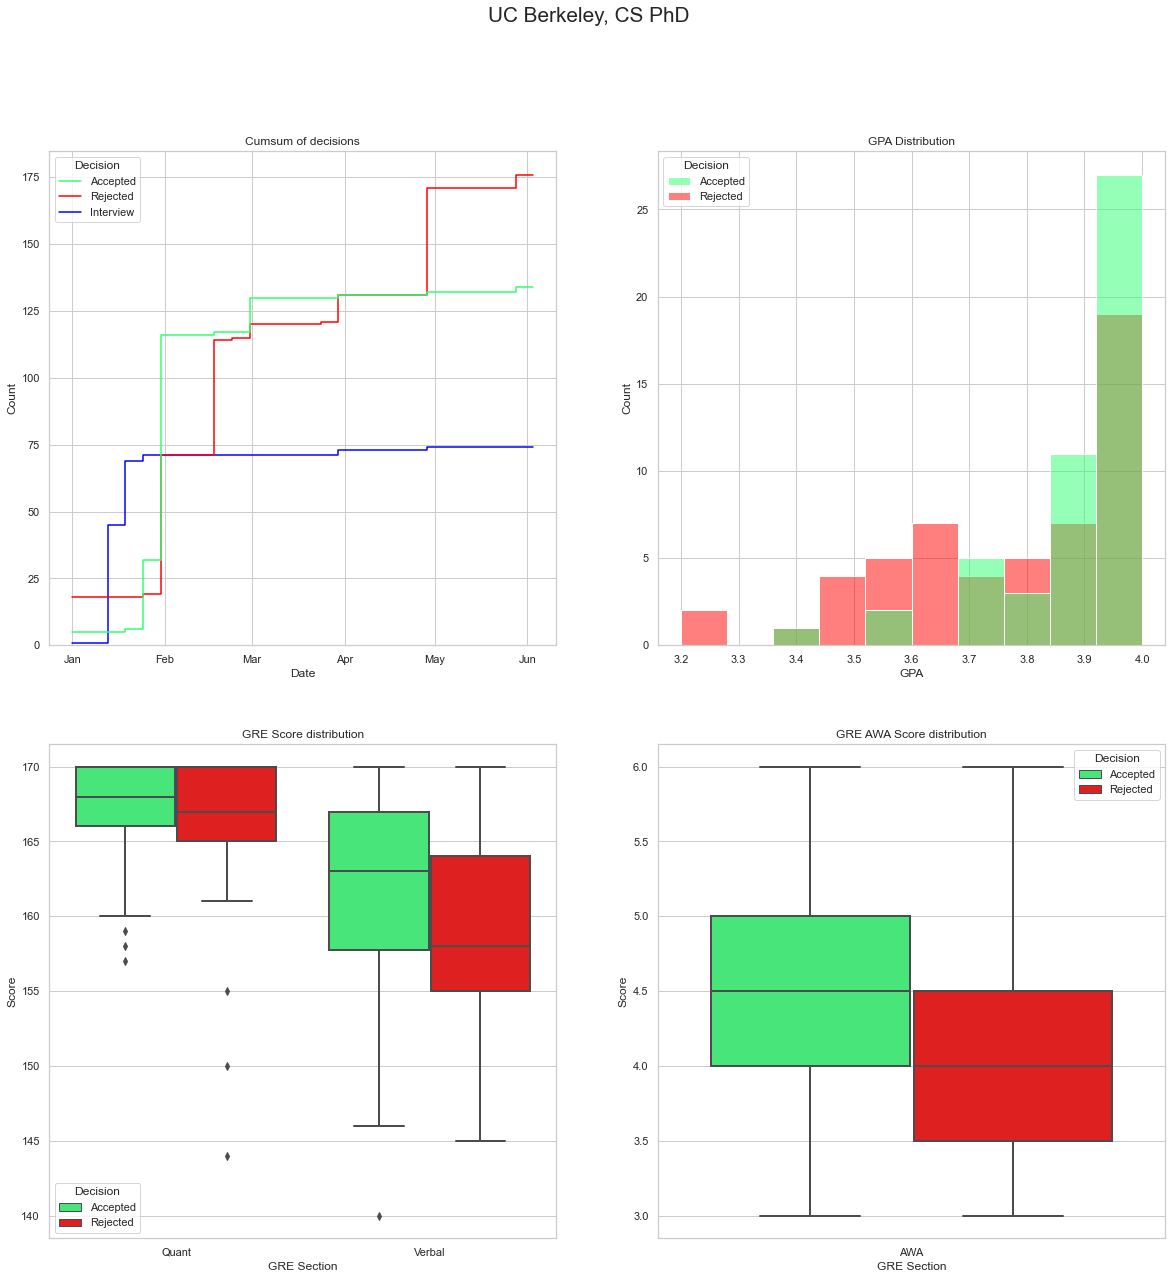

In [658]:
get_uni_stats(df_1720, search='berkeley', title='UC Berkeley', degree='PhD', field='CS')

## Other things you could analyze

For instance how many interviews per university, and thus know how likely it is that the interview process is a must if you wanna be accepted.

### Bad interview analysis

In [ ]:
df_1720['is_int'] = 0

In [ ]:
df_1720.loc[df_1720['decisionfin'] == 'Interview', 'is_int'] = 1

In [651]:
df_1720.groupby(by='institution').agg({'is_int': sum}).sort_values(by='is_int', ascending=False).head(10)

,is_int
institution,
Columbia University,90
University Of Oxford,59
Stanford University,57
University Of Toronto,39
Massachusetts Institute Of Technology (MIT),32
UC Berkeley,30
The University Of Toronto,29
"University Of California, Berkeley",25
Carnegie Mellon University,25


# Analyze other fields: History Analysis

In [659]:
hisdf = pd.read_csv("data/history.csv", index_col=0)

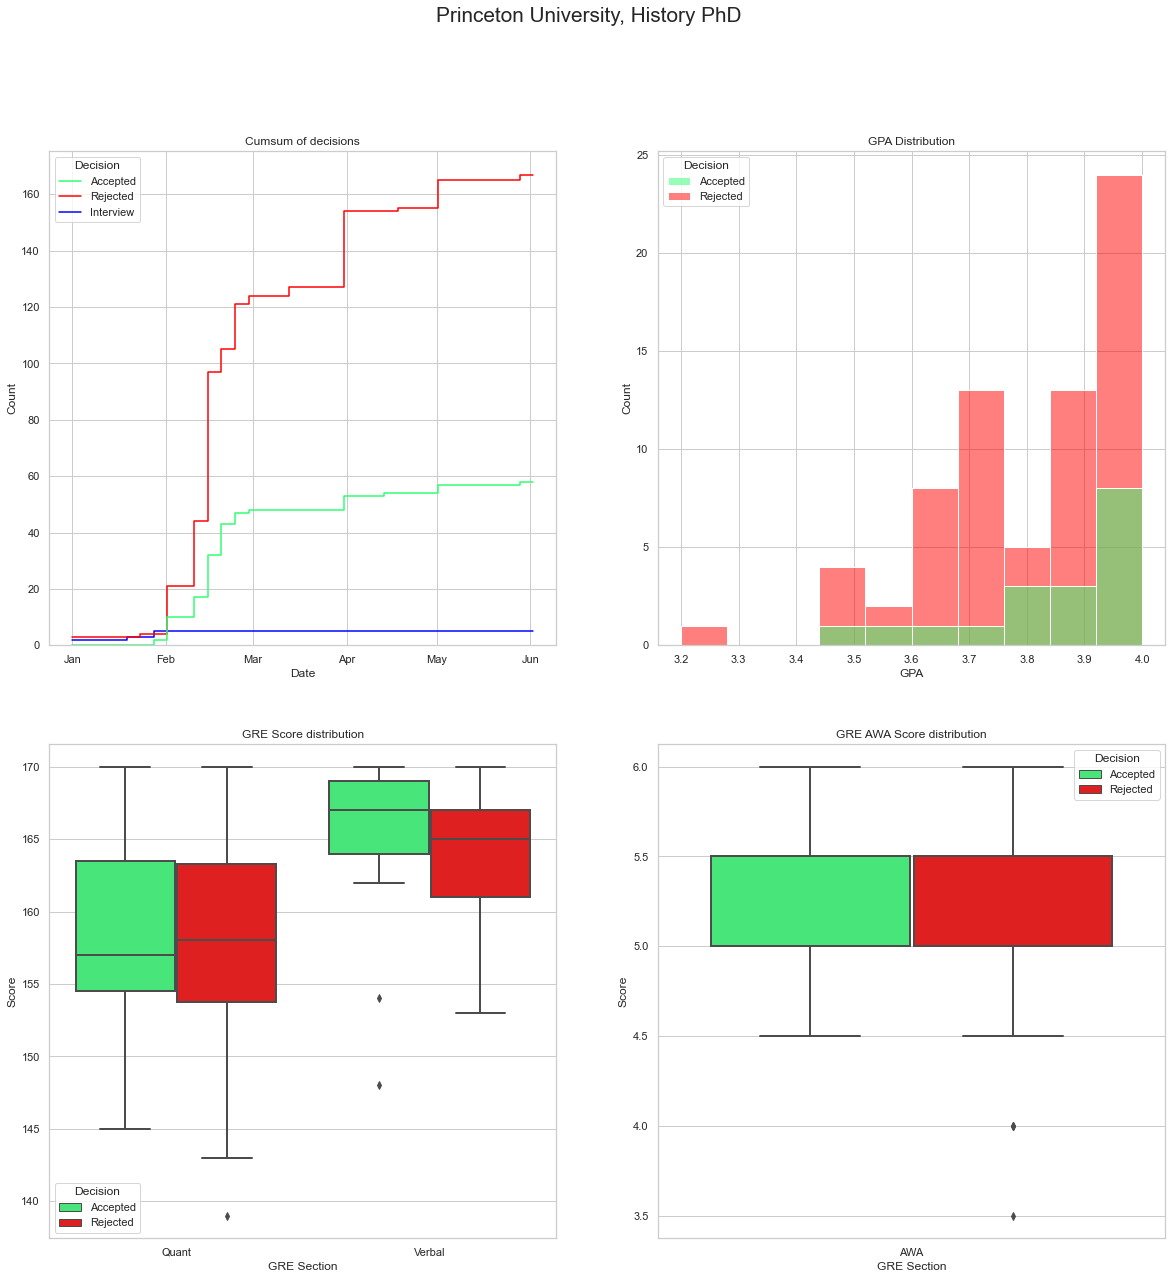

In [660]:
get_uni_stats(hisdf, search='Princeton', title='Princeton University', degree='PhD', field='History')